# Idea:
A partire da un audio contenente una semplice sequenza di note suonate con la chitarra classica a 6 corde, riconoscere le note utilizzate nell'ordine giusto e, eventualmente, comporre uno spartito.

Il programma cercherà di ridurre eventuale rumore di sottofondo dall'audio passato in input.

In [1]:
import IPython as ip
import librosa as lb
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
input_audio = "EABGDE.wav"
audio, sample_rate = lb.load("Audio/" + input_audio)
ip.display.Audio(audio, rate=sample_rate)

## Obiettivo 1: Riduzione del rumore
L'idea è quella di usare un filtro sulla trasformata di Fourier e poi ricostruire il segnale "pulito" con l'inversa della trasformata di Fourier

In [3]:
def gaussian(sigma,n):
    x = np.linspace(-n//2,n//2, n)
    bump = np.exp(-x**2/2.*sigma**2)
    bump /= np.trapezoid(bump) # normalize the integral to 1
    return x, bump

In [4]:
x,y = gaussian(0.15,audio.size)
y_shifted = np.fft.fftshift(y)
fft_gauss = np.fft.fft(y_shifted)

Fourier = np.fft.fft(audio)
frequency = np.fft.fftfreq(audio.size, d=1/sample_rate)
Filtered_Fourier = np.multiply(Fourier, fft_gauss)
filtered_audio = np.fft.ifft(Filtered_Fourier)

## Plot

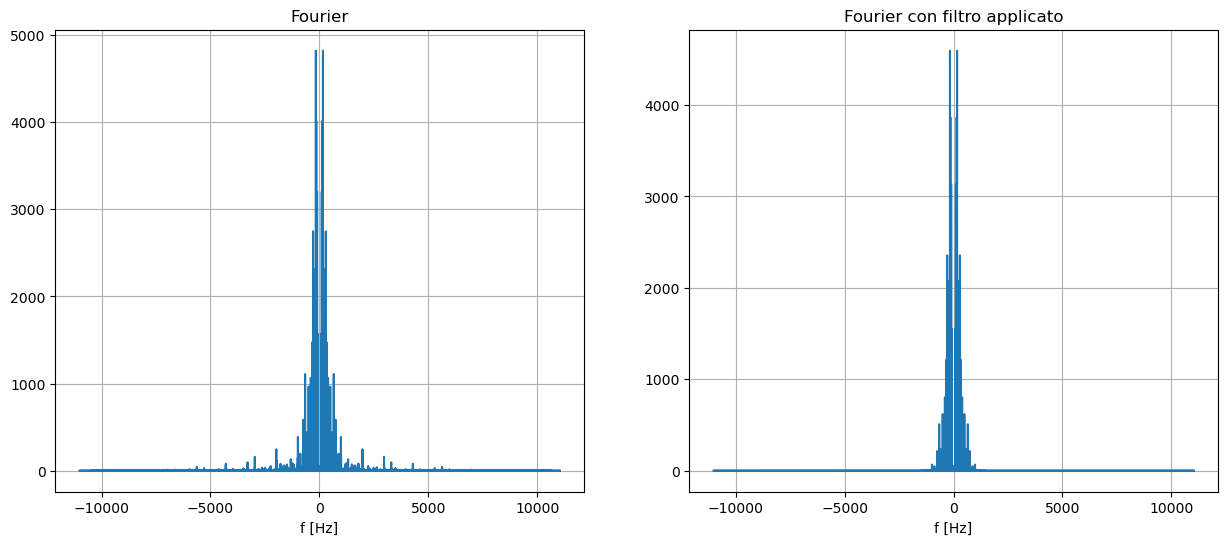

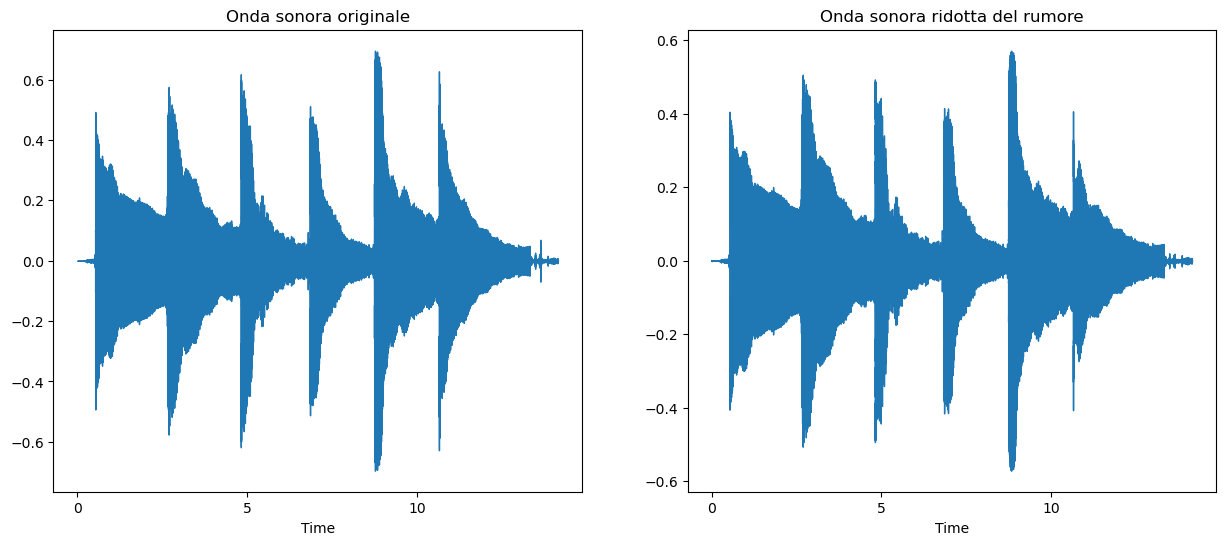

In [5]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(np.fft.ifftshift(frequency),np.abs(np.fft.ifftshift(Fourier)))
#plt.plot(freq_sound, np.abs(fourier))
plt.xlabel('f [Hz]')
plt.title('Fourier')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(np.fft.ifftshift(frequency),np.abs(np.fft.ifftshift(Filtered_Fourier)))
#plt.plot(freq_sound, np.abs(filtered_fourier))
plt.xlabel('f [Hz]')
plt.title('Fourier con filtro applicato')
plt.grid()

plt.show()

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
lb.display.waveshow(audio, sr=sample_rate)
plt.title('Onda sonora originale')

plt.subplot(1, 2, 2)
lb.display.waveshow(filtered_audio.real, sr=sample_rate)
plt.title('Onda sonora ridotta del rumore')

plt.show()

In [6]:
print("Audio originale")
ip.display.display(ip.display.Audio(audio, rate=sample_rate))
print("Audio filtrato")
ip.display.display(ip.display.Audio(filtered_audio.real, rate=sample_rate))

Audio originale


Audio filtrato


## Obiettivo 2: Scomposizione del segnale audio
Qui scomporremo il segnale audio (pulito) in segmenti utilizzando la funzione
```
librosa.onset()
```
e ogni segmento sarà composto da, teoricamente, una singola nota

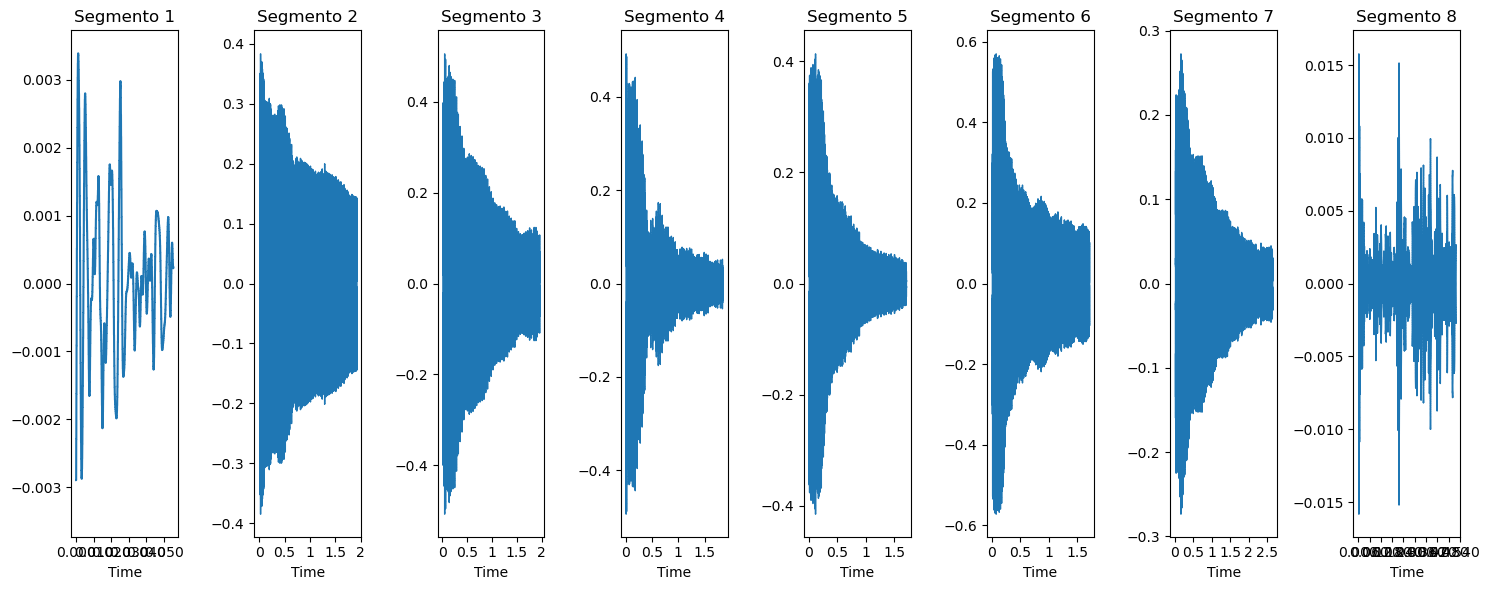

In [ ]:
onset_frames = lb.onset.onset_detect(y=filtered_audio.real, sr=sample_rate)
segments = []

time_trim = 0.2 # s
time_to_samples_trim = lb.time_to_samples(times=time_trim, sr=sample_rate)

for i in range(len(onset_frames)):
    start_frame = onset_frames[i]

    if i + 1 < len(onset_frames):
        end_frame = onset_frames[i + 1]
    else:
        end_frame = filtered_audio.size

    start_sample = lb.frames_to_samples(start_frame)

    end_sample = lb.frames_to_samples(end_frame)

    segment = filtered_audio[start_sample:(end_sample-time_to_samples_trim)]

    if segment.size > 0:
      
        

        segments.append(segment)

plt.figure(figsize=(15, 6))

for i, segment in enumerate(segments):
    plt.subplot(1, len(segments), i + 1)
    lb.display.waveshow(segment.real, sr=sample_rate)
    plt.title(f"Segmento {i+1}")
    plt.tight_layout()
plt.show()

In [8]:
for i, segment in enumerate(segments):
    print(f"Segmento {i+1}, forza: " + str(max(lb.onset.onset_strength(y=segment.real, sr=sample_rate))) + ", durata: " + str(lb.get_duration(y=segment.real, sr=sample_rate)) + ", ampiezza: " + str(np.max(np.abs(segment.real))))
    ip.display.display(ip.display.Audio(segment.real, rate=sample_rate))

Segmento 1, forza: 0.0, durata: 0.055419501133786846, ampiezza: 0.003390317840118173


d:\Programmi\anaconda\envs\ProgettoFESI\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1222
  warnings.warn(


Segmento 2, forza: 0.3416829359430414, durata: 1.913015873015873, ampiezza: 0.3840624902428154


Segmento 3, forza: 0.8104816216986468, durata: 1.9594557823129253, ampiezza: 0.5061906711783302


Segmento 4, forza: 0.6591655013451618, durata: 1.8433560090702947, ampiezza: 0.49340243963390035


Segmento 5, forza: 0.2723068348892268, durata: 1.7040362811791383, ampiezza: 0.4144191404146577


Segmento 6, forza: 0.43582716001247773, durata: 1.7040362811791383, ampiezza: 0.5714751327490879


Segmento 7, forza: 0.43048810790023356, durata: 2.6328344671201815, ampiezza: 0.2731030659588658


Segmento 8, forza: 1.0785553406384691, durata: 0.5152380952380953, ampiezza: 0.015802118489305066


## Obiettivo 3: Riconoscimento della nota
Per ogni segmento che abbiamo trovato, calcoleremo la Trasformata di Fourier e guarderemo qual è la frequenza dominante, dopodichè mapperemo questa frequenza cercando la nota più vicina nel nostro dizionario.

## Dizionari

In [26]:
musical_notes = {
    "a,,": 27.5,
    "a,": 55,
    "a": 110,
    "a'": 220,
    "a''": 440,
    "a'''": 880,
    "b,,": 30.87,
    "b,": 61.74,
    "b": 123.47,
    "b'": 246.94,
    "b''": 493.88,
    "b'''": 987.77,
    "d,,": 18.35,
    "d,": 36.71,
    "d": 73.42,
    "d'": 146.83,
    "d''": 293.66,
    "d'''": 587.33,
    "e,,": 20.6,
    "e,": 41.2,
    "e": 82.41,
    "e'": 164.81,
    "e''": 329.63,
    "e'''": 659.25,
    "g,,": 24.5,
    "g,": 49,
    "g": 98,
    "g'": 196,
    "g''": 392,
    "g'''": 783.99,
}

In [10]:
simple_musical_notes = {
    "A": [27.5, 55, 110, 220, 440, 880],
    "B": [30.87, 61.74, 123.47, 246.94, 493.88, 987.77],
    "D": [18.35, 36.71, 73.42, 146.83, 293.66, 587.33],
    "E": [20.6, 41.2, 82.41, 164.81, 329.63, 659.25],
    "G": [24.5, 49, 98, 196, 392, 783.99],
}

## Codice

Frequenze prese da:
- https://muted.io/note-frequencies/
- https://mixbutton.com/mixing-articles/music-note-to-frequency-chart/
- https://en.wikipedia.org/wiki/Guitar_tunings

Secondo Wikipedia le frequenze delle note delle corde di una chitarra classica partono dalla seconda ottava, infatti la seconda ottava più bassa è 65 Hz

<b>Problema noto: </b> se ci sono note "sovrapposte" vince quella più grave

In [ ]:
cutoff_freq_max = 987.77 # (Hz)
cutoff_freq_min = 65 # (Hz)

segments_Fourier = []
debug = []

for i, segment in enumerate(segments):
    if np.max(np.abs(segment.real)) < 0.1:
      continue

    to_append = [
        (i, np.fft.fft(segment), np.fft.fftfreq(segment.size , 1 / sample_rate))
    ]
    segments_Fourier.extend(to_append)

dominants_frequency = []
for i, segment_Fourier, segment_frequency in segments_Fourier:
    dominant_frequency = np.abs(segment_frequency[np.argmax(np.abs(segment_Fourier))])

    if dominant_frequency >= cutoff_freq_min and dominant_frequency <= cutoff_freq_max:
      print(f"Segmento {i+1}: {dominant_frequency} Hz")
      dominants_frequency.append(dominant_frequency)
    else:
      print(f"Segmento {i+1}: {dominant_frequency} Hz (eliminato)")


Segmento 2: 163.09326252904083 Hz
Segmento 3: 108.70365227051798 Hz
Segmento 4: 247.37489543866553 Hz
Segmento 5: 197.1789003034013 Hz
Segmento 6: 144.9499654016075 Hz
Segmento 7: 145.0907775519344 Hz


In [12]:
def find_nearest_note(freq):
    if freq is None:
        raise ValueError("La frequenza fornita è nulla")

    try:
      min_diff = float('inf')
      nearest_note = None

      for note, note_freq in musical_notes.items():
          diff = abs(freq - note_freq)
          if diff < min_diff:
              min_diff = diff
              nearest_note = note

      return nearest_note
    except Exception as e:
      print(f"Si è verificato un errore: {e}")
      return None

In [13]:
def find_nearest_simple_note(freq):
    if freq is None:
        raise ValueError("La frequenza fornita è nulla")

    try:
      min_diff = float('inf')
      nearest_note = None

      for note, freqs in simple_musical_notes.items():
          for note_freq in freqs:
              diff = abs(freq - note_freq)
              if diff < min_diff:
                  min_diff = diff
                  nearest_note = note

      return nearest_note
    except Exception as e:
      print(f"Si è verificato un errore: {e}")
      return None

In [33]:
print(f"File di input: {input_audio}")
notes = [find_nearest_simple_note(freq) for freq in dominants_frequency]
print(notes)

File di input: EABGDE.wav
['E', 'A', 'B', 'G', 'D', 'D']


## Obiettivo 4 (opzionale): Costruzione dello spartito
In base alle note che abbiamo trovato costruiremo lo spartito.
Per poter usare questa parte bisogna avere installato ```lilypond```

In [15]:
import abjad

In [ ]:
complex_notes = [find_nearest_note(freq) for freq in dominants_frequency]
abjad_notes = [abjad.Note(note) for note in complex_notes]
staff = abjad.Staff(abjad_notes)
abjad.show(staff)